In [20]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p skin_cancer

{"username":"nassimbout","key":"f29d140df6032cb4d276323ad8bf570c"}Downloading skin-cancer-mnist-ham10000.zip to skin_cancer
100% 5.19G/5.20G [01:14<00:00, 41.9MB/s]
100% 5.20G/5.20G [01:14<00:00, 75.1MB/s]


In [22]:
!unzip -q /content/skin_cancer/skin-cancer-mnist-ham10000.zip -d /skin_data_up

In [24]:
import os
import shutil

# --------------------------------------------------------
reorg_dir = "/skin_data_up/ham10000_images_part_2"
target_dir = "/skin_data_up/ham10000_images" 
# ---------------------------------------------------------
for root, dirs, files in os.walk(reorg_dir):
    for name in files:
        subject = root+"/"+name
        n = 1; name_orig = name
        while os.path.exists(target_dir+"/"+name):
            name = "duplicate_"+str(n)+"_"+name_orig; n = n+1
        newfile = target_dir+"/"+name; shutil.move(subject, newfile)

In [7]:
rm -rf /skin_data_up/data_split3

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: typing-extensions, protobuf, wheel, astunparse, six, h5py, termcolor, grpcio, tensorflow-estimator, keras-preprocessing, wrapt, flatbuffers, numpy, opt-einsum, gast, google-pasta, absl-py, tensorboard
Required-by: fancyimpute


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cellule ci-dessous : split de data

0


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.


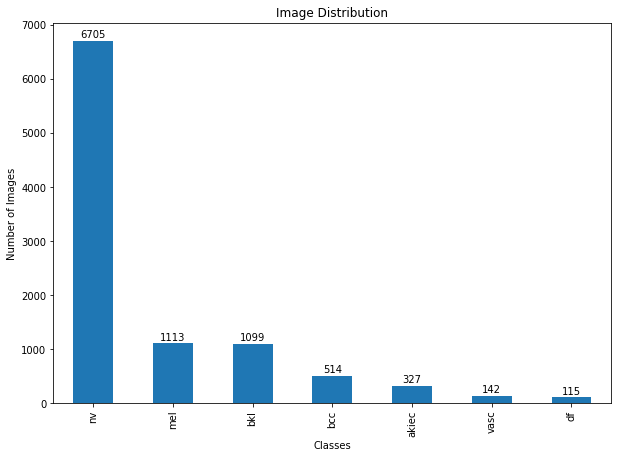

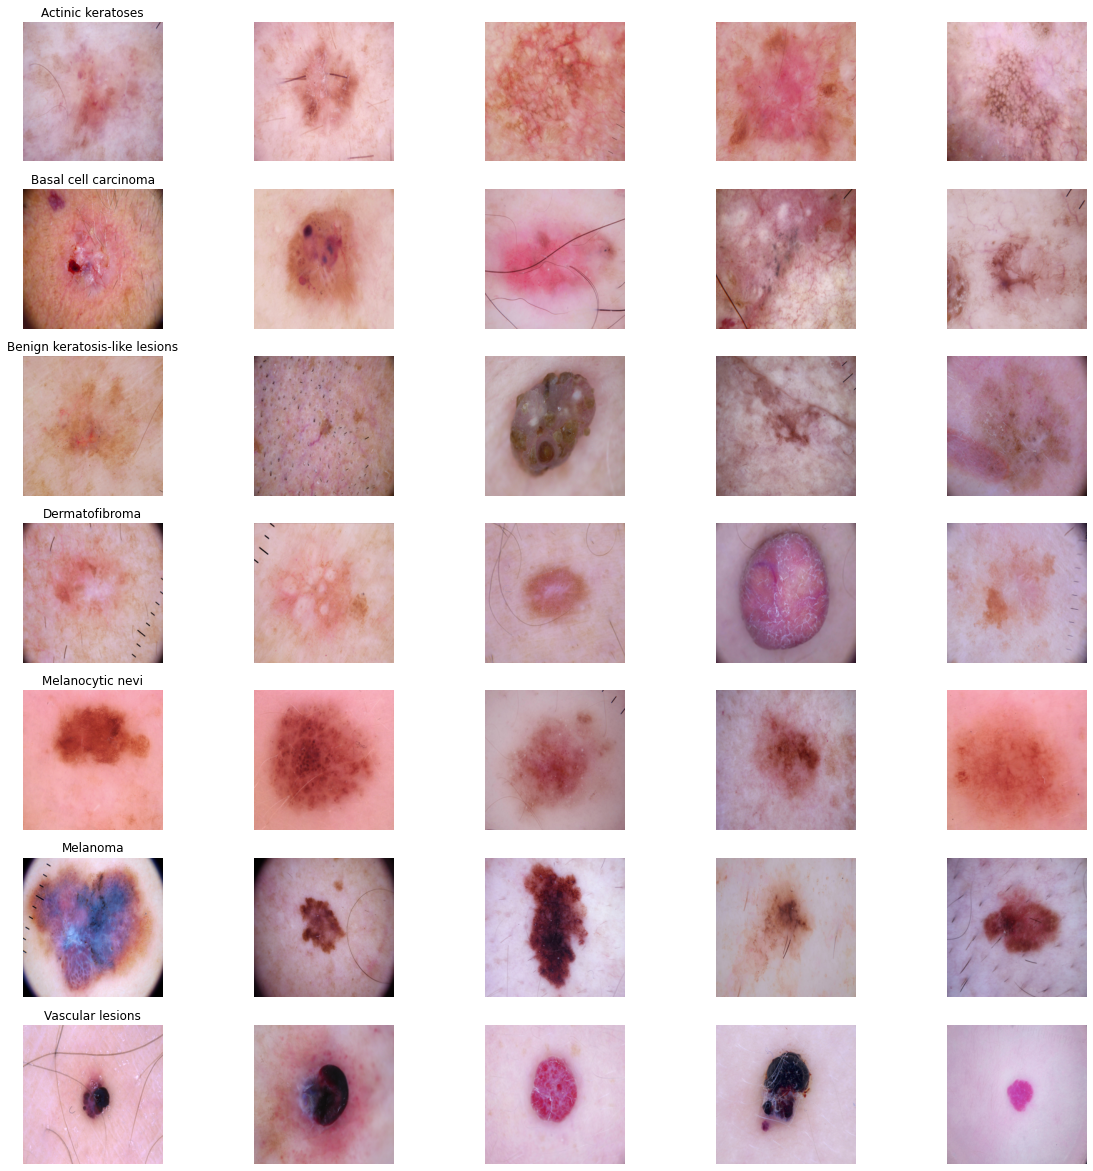

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image, ImageFile
import imageio

from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

def add_value_labels(ax, spacing=1):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = y_value

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# get dictionary with all file name in .jpg
base_dir = '/skin_data_up/ham10000_images'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir, '*', '*.jpg'))}
print(len(imageid_path_dict))

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Read in the csv of metadata
tile_df = pd.read_csv(os.path.join(base_dir, '/skin_data_up/HAM10000_metadata.csv'))

# Create some new columns (path to image, human-readable name) and review them
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

# distribution of different cell types
fig, ax1 = plt.subplots(1, 1, figsize= (10, 7))
tile_df['dx'].value_counts().plot(kind='bar', ax=ax1)
plt.title('Image Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
add_value_labels(ax1)

fig.savefig('Distribution.png')


ImageFile.LOAD_TRUNCATED_IMAGES = True
#Image.open('/content/drive/MyDrive/dataset-skin/HAM10000_images/ISIC_0028905.jpg').resize((224,224))
tile_df['image'] = ('/skin_data_up/ham10000_images/'+tile_df['image_id']+'.jpg').map(lambda x: np.asarray(Image.open(x).resize((224,224))))

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

y = tile_df.cell_type_idx

#make training, validation, and test split of the data
from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.2)


# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

x_train, x_validate, y_train, y_validate = train_test_split(x_train_o, y_train, test_size = 0.25)
'''
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))
'''

#create split folders for the data set
data_path = '/skin_data_up/data_split2'
# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(data_path, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(data_path, 'val_dir')
os.mkdir(val_dir)

#test_dir
test_dir = os.path.join(data_path, 'test_dir')
os.mkdir(test_dir)

def make_cat_folders(path):
    nv = os.path.join(path, 'nv')
    os.mkdir(nv)
    mel = os.path.join(path, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(path, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(path, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(path, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(path, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(path, 'df')
    os.mkdir(df)
    
make_cat_folders(train_dir)
make_cat_folders(val_dir)
make_cat_folders(test_dir)

def save_split(path, data):
    images = data['image'].tolist()
    image_id = data['image_id'].tolist()
    image_dx = data['dx'].tolist()
    
    for i in range(len(images)):
        images[i] = images[i]*(1/255)
    
    for i in range(len(images)):
        imageio.imwrite((path+'/'+image_dx[i]+'/'+image_id[i]+'.jpg'), images[i])

save_split(train_dir, x_train)
save_split(test_dir, x_test_o)
save_split(val_dir, x_validate)


Cellule ci-dessous : Data augmentation

In [5]:
from numpy.random import seed
import tensorflow
seed(101)
tensorflow.random.set_seed(101)
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil

path='/skin_data_up/ham10000_images'
path2 = '/skin_data_up/data_split2'

# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = '/skin_data_up/aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir(path2+'/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join(path2+'/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = path2+'/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 700 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('/skin_data_up/aug_dir')
    
print(len(os.listdir(path2+'/train_dir/nv')))
print(len(os.listdir(path2+'/train_dir/mel')))
print(len(os.listdir(path2+'/train_dir/bkl')))
print(len(os.listdir(path2+'/train_dir/bcc')))
print(len(os.listdir(path2+'/train_dir/akiec')))
print(len(os.listdir(path2+'/train_dir/vasc')))
print(len(os.listdir(path2+'/train_dir/df')))

Found 686 images belonging to 1 classes.
Found 672 images belonging to 1 classes.
Found 316 images belonging to 1 classes.
Found 195 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Found 72 images belonging to 1 classes.
3977
736
722
682
735
687
554


In [8]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt


def normalize_color_image(img_path):
    image = cv2.imread(img_path)
    channels = cv2.split(image)
    eq_channels = []
    for ch, color in zip(channels, ['B', 'G', 'R']):
        eq_channels.append(cv2.equalizeHist(ch))

    eq_image = cv2.merge(eq_channels)
    eq_image = cv2.cvtColor(eq_image, cv2.COLOR_BGR2RGB)
    return eq_image
    
    


train_path = '/skin_data_up/data_split2/train_dir' 
valid_path = '/skin_data_up/data_split2/val_dir' 
test_path = '/skin_data_up/data_split2/test_dir'

train_pics = glob(train_path+"/*/*.jpg")
val_pics = glob(valid_path+"/*/*.jpg")
test_pics = glob(test_path+"/*/*.jpg")

for pic in train_pics:
    img = normalize_color_image(pic)
    cv2.imwrite(pic, img)
for pic in val_pics:
    img = normalize_color_image(pic)
    cv2.imwrite(pic, img)
for pic in test_pics:
    img = normalize_color_image(pic)
    cv2.imwrite(pic, img)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

from keras import models
from keras.preprocessing import image


def save_training_graph(history, filename):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    
    ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    fig.savefig(filename)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion_Matrix.png')
    
def vis_activation(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    
    plt.imshow(img_tensor[0])
    plt.show()
    print(img_tensor.shape)
    
    layer_outputs = [layer.output for layer in model.layers[1:19]] 
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
    # Creates a model that will return these outputs, given the model input
    
    activations = activation_model.predict(img_tensor)
    
    layer_names = []
    for layer in model.layers[1:19]:
    	layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    	
    images_per_row = 16
    
    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    	n_features = layer_activation.shape[-1] # Number of features in the feature map
    	width = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    	height = layer_activation.shape[2]
    	n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    	display_grid = np.zeros((width * n_cols, images_per_row * height))
    	
    	for col in range(n_cols): # Tiles each filter into a big horizontal grid 
    		for row in range(images_per_row):
    			channel_image = layer_activation[0,:, :,col * images_per_row + row]
    			channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
    			channel_image /= channel_image.std()
    			channel_image *= 64
    			channel_image += 128
    			channel_image = np.clip(channel_image, 0, 255).astype('uint8')
    			display_grid[col * width : (col + 1) * width, # Displays the grid
    						 row * height : (row + 1) * height] = channel_image
    	#scale = 1. / (224)
    	#plt.figure(figsize=(scale * display_grid.shape[1],
    	#					scale * display_grid.shape[0]))
    	plt.title(layer_name)
    	plt.grid(False)
    	plt.imshow(display_grid, aspect='auto', cmap='viridis')
    	plt.savefig('layer_'+layer_name+'.png')

Cellule ci-dessous : Training 


In [ ]:
import numpy as np
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras.optimizers 
from model_utils import save_training_graph, plot_confusion_matrix, vis_activation
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.vgg16 import preprocess_input

base_model=VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3))

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(1024,activation='relu'))
top_model.add(Dropout(.50))
top_model.add(Dense(512,activation='relu'))
top_model.add(Dropout(.25))

top_model.add(Dense(7,activation='softmax')) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=top_model(base_model.output))
print(model.summary())

#Each one of those commands represents one experiment with trainable layers
'''
for layer in model.layers[:20]:
    layer.trainable = False
   
for layer in model.layers[1:7]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = False
for layer in model.layers:
    print(layer, layer.trainable)
'''

train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen=ImageDataGenerator(
        preprocessing_function=preprocess_input)

train_path = '/skin_data_up/data_split2/train_dir' 
valid_path = '/skin_data_up/data_split2/val_dir' 
test_path = '/skin_data_up/data_split2/test_dir' 

train_generator = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

valid_gen = valid_datagen.flow_from_directory(valid_path,
                                            target_size=(224,224),
                                            color_mode = "rgb",
                                            class_mode="categorical",
                                            batch_size=10)

test_gen = valid_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            color_mode = "rgb",
                                            class_mode="categorical",
                                            batch_size=1,
                                            shuffle=False)

# loss function will be categorical cross entropy
# evaluation metric will be accuracy
sgd = keras.optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=.00001)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

checkpointer = ModelCheckpoint(filepath="best_weights_model.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

step_size_train=train_generator.n//train_generator.batch_size
step_size_val=valid_gen.n//valid_gen.batch_size

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   callbacks=[checkpointer,learning_rate_reduction,early_stop],
                   validation_data=valid_gen,
                   validation_steps=step_size_val,
                   epochs=50)

model = load_model('best_weights_model.hdf5')
scores = model.evaluate_generator(generator=test_gen,steps=test_gen.n//test_gen.batch_size)
print(str(scores[0]), str(scores[1]))

Y_pred = model.predict_generator(test_gen,test_gen.n//test_gen.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
confusion_mtx=confusion_matrix(test_gen.classes, y_pred)
print(confusion_mtx)
plot_confusion_matrix(confusion_mtx, classes = range(7))

print('Classification Report')
target_names = ['akiec','bcc','bkl','df','mel','nv','vasc']
print(classification_report(test_gen.classes, y_pred,target_names=target_names))

save_training_graph(history, 'Pretrained Training Accuracy')